The idea of this optimizer is to find the most optimal portfolio in terms of low correlation, high past returns, diverse country and branch distribtution 

toDO:
- add etf composition chart
- add etf top 10 most value stocks
- add anual return of ytd, past 5 years
- add weight to do portfolio analysis
- clean up code, still super messy

In [6]:
# save as etf_correlation.py and run: python etf_correlation.py
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [7]:
# Use Tickers (Xetra/EUR), not ISINs
tickers = [
    "INRG.L", # Global Clean Energy
    "URTH", # MSCI World
    "IEUR", # MSCI Europe
    "EEM", # MSCI Emerging Markets
    "IVE", # S&P 500
]

In [8]:
# Load historical price data from CSV file
if not os.path.exists("etf_historical_data.csv"):
    raise FileNotFoundError("etf_historical_data.csv not found. Please provide the CSV file with ETF price data.")

# Read CSV with long format (Date, Ticker columns)
df = pd.read_csv("etf_historical_data.csv")
print(f"Loaded {len(df)} rows from etf_historical_data.csv")
print(f"Unique tickers: {df['Ticker'].unique()}")

# Convert Close to numeric, coerce errors to NaN
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Parse dates and normalize to remove timezone info
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None).dt.normalize()

print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# Pivot to wide format: rows=dates, columns=tickers, values=Close prices
prices = df.pivot(index='Date', columns='Ticker', values='Close')

print(f"\nBefore cleaning - shape: {prices.shape}")
print(f"NaN counts per ticker:\n{prices.isna().sum()}")

# Forward fill missing values (more generous limit for weekends/holidays)
prices = prices.ffill(limit=10)

# Drop columns (tickers) that have too many NaNs (e.g., more than 20% missing)
threshold = len(prices) * 0.8  # Keep columns with at least 80% valid data
prices = prices.dropna(axis=1, thresh=threshold)

# Now drop rows that still have NaNs
prices = prices.dropna(axis=0)

print(f"\nAfter cleaning - shape: {prices.shape}")
print(f"Tickers in prices: {list(prices.columns)}")
print(f"Date range in prices: {prices.index.min()} to {prices.index.max()}")
print(f"\nFirst few rows:")
print(prices.head())
print(f"\nLast few rows:")
print(prices.tail())

Loaded 6275 rows from etf_historical_data.csv
Unique tickers: ['INRG.L' 'URTH' 'IEUR' 'EEM' 'IVE']
Date range: 2020-12-10 00:00:00 to 2025-12-09 00:00:00

Before cleaning - shape: (1422, 5)
NaN counts per ticker:
Ticker
EEM       168
IEUR      168
INRG.L    163
IVE       168
URTH      168
dtype: int64

After cleaning - shape: (1422, 5)
Tickers in prices: ['EEM', 'IEUR', 'INRG.L', 'IVE', 'URTH']
Date range in prices: 2020-12-10 00:00:00 to 2025-12-09 00:00:00

First few rows:
Ticker            EEM       IEUR       INRG.L         IVE        URTH
Date                                                                 
2020-12-10  45.631317  43.704819  1008.053833  115.747154  102.345062
2020-12-11  45.309708  43.421631  1023.546875  115.357101  102.058678
2020-12-14  45.074135  43.445034  1032.542847  114.116707  102.053078
2020-12-15  45.561520  44.034348  1059.031250  115.732231  103.160446
2020-12-16  45.778141  44.259678  1057.532227  115.339767  103.402382

Last few rows:
Ticker        

Ticker                 MSCI Emerging Markets  MSCI Europe  \
Ticker                                                      
MSCI Emerging Markets               1.000000     0.748150   
MSCI Europe                         0.748150     1.000000   
Global Clean Energy                 0.155024     0.129185   
S&P 500                             0.601100     0.757670   
MSCI World                          0.740687     0.853553   

Ticker                 Global Clean Energy   S&P 500  MSCI World  
Ticker                                                            
MSCI Emerging Markets             0.155024  0.601100    0.740687  
MSCI Europe                       0.129185  0.757670    0.853553  
Global Clean Energy               1.000000  0.123594    0.156637  
S&P 500                           0.123594  1.000000    0.899790  
MSCI World                        0.156637  0.899790    1.000000  


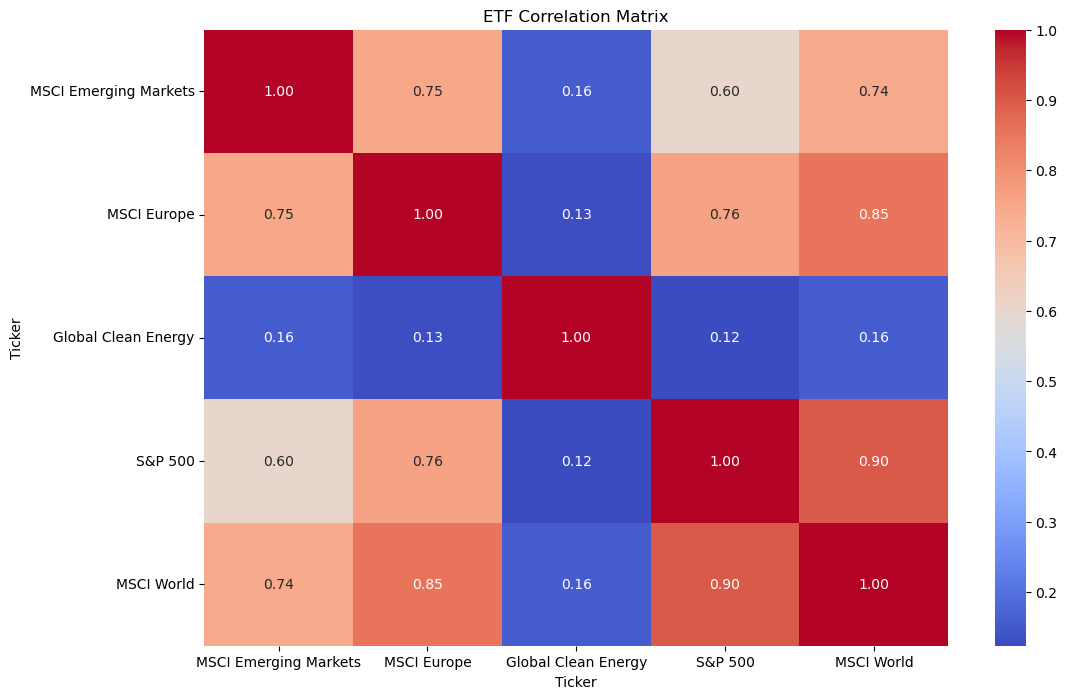

In [9]:
#calculate the correlation for all etfs for the past 5 years
returns = prices.pct_change().dropna()
correlation_matrix = returns.corr()
#add names instead of tickers
etf_names = {
    "INRG.L": "Global Clean Energy",
    "URTH": "MSCI World",
    "IEUR": "MSCI Europe",
    "EEM": "MSCI Emerging Markets",
    "EXXT.DE": "NASDAQ",
    "IVE": "S&P 500"
}
correlation_matrix.rename(index=etf_names, columns=etf_names, inplace=True)


print(correlation_matrix)
#plot the correlation matrix as a heatmap and add names instead of tickers
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.title("ETF Correlation Matrix")
plt.show()

In [10]:
# get stock holdings for the ETFs using yfinance data
